# CardIO framework for deep research of ECG

#### CardIO is based on a very simple and natural approach:

* Split input dataset into batches to process data batch by batch (because input datasets can be indefinitely large)
* Describe workflow as a sequence of actions (e.g. load data — preprocess data — train model)
* Run the workflow once for the whole dataset

#### In this notebook you will learn:
* Where to get ECG data
* How to start using CardIO
* How to apply actions to batch
* What actions can be applied to batch and how they affect batch

## Table of contents

* [Getting ECG data](#Getting-ECG-data)
* [Index of ECGs](#Index-of-ECGs)
* [Initialization of dataset](#Initialization-of-dataset)
* [Start using dataset](#Start-using-dataset)
* [Generating batches](#Generating-batches)
* [Apply actions](#Apply-actions)
* [Actions in CardIO](#Actions-in-CardIO)
    * [convolve_signals](#convolve_signals)
    * [band_pass_signals](#band_pass_signals)
    * [random_split_signals](#random_split_signals)
    * [unstack_signals](#unstack_signals)
    * [resample_signals](#resample_signals)
    * [spectrogram](#spectrogram)
    * [fft](#fft)
    * [apply_transform](#apply_transform)
    * [drop_labels](#drop_labels)
    * [rename_labels](#rename_labels)
    * [rename_channels](#rename_channels)
* [Summary](#Summary)

## Getting ECG data

In this and following tutorials you will work with ECG data throught CardIO framework. 

We suggest loading ECG data from the PhysioNet database of short single lead ECG recording. Follow this [link](https://physionet.org/challenge/2017/) and find archive "training2017.zip" or use [direct](https://physionet.org/challenge/2017/training2017.zip) link. However, if you do not want to load large dataset now, you can find several ECGs from that database in folder cardio/tests/data (this folder is icluded in CardIO repository).

The PhysioNet archive contains 8.528 ECGs in [wfdb](https://www.physionet.org/physiotools/wpg/wpg_35.htm) format. Each ECG has a unique index ranging from "A00001" to "A08528". According to wbdf format ECG record consists of several files with the same name but different extensions. We will work with files with ```.hea``` and ```.mat``` extensions. File ```.hea``` contains signal, while ```.mat``` contains meta information about the signal (e.g. sample rate). 

Since the PhysioNet acrhive was prepared for arrhythmia classification challenge, it also contains REFERENCE.csv file, where each ECG index is labeled with one of four classes:
* Normal rhythm
* AF
* Other rhythm
* Noise

Read [here](https://physionet.org/challenge/2017/) more about PhysioNet database.

## Index of ECGs

Working with ECG begins with ```FilesIndex```. ```FilesIndex``` contains index and location of each ECG record we want to process. 

Let all ECGs be stored in wfdb format in folder with path '../cardio/tests/data/' (if you cloned the CardIO repository from [Git](https://github.com/analysiscenter/cardio), this path will actually contain several examples of ECGs). Let's create a new ```FilesIndex``` with all ECGs from this folder.

In [1]:
import sys
import numpy as np

from matplotlib import pyplot as plt

sys.path.append('..')

import cardio.dataset as ds
index = ds.FilesIndex(path='../cardio/tests/data/A*.hea', no_ext=True, sort=True)

Now each ECG is indexed with its filename. Indices are stored in ```index.indices```:

In [2]:
print(index.indices)

['A00001' 'A00002' 'A00004' 'A00005' 'A00008' 'A00013']


## Initialization of Dataset

We have ```index``` that knows which ECGs we want to process. CardIO processes data grouped in batches of class [EcgBatch](https://analysiscenter.github.io/cardio/intro/batch.html). To generate proper batches we create a dataset:

In [3]:
from cardio import EcgBatch
eds = ds.Dataset(index, batch_class=EcgBatch)

Note that the same result can be obtained in a shorter way:
```python
from cardio import EcgDataset
eds = EcgDataset(path='../cardio/tests/data/*.hea', no_ext=True, sort=True)
```

## Generating batches

Let's generate a first batch of some size, say 6:

In [4]:
batch = eds.next_batch(batch_size=6, unique_labels=['A', 'N', 'O'])

Here we pass argument ```unique_labels```, which contains all possible labels that we expect to be in the dataset. We have ECG signals with three different labels that indicate whether the ECG has come from a person with normal rhythm (label "N"), a person with atrial fibrillation ("A"), or a person with some other abnormal rhythm ("O"). 

However ```batch``` still does not contain any data, only indices and paths to ECGs. To fill it with data we need to apply load action. Next section shows how to apply actions.

## Apply actions

Any preprocess typically begins with loading of data. Therefore, we start with an example how to apply action [```load```](https://analysiscenter.github.io/cardio/api/cardio.batch.html#cardio.batch.EcgBatch.load). 

Note that paths to ECGs are already stored in batch, so simply inticate data format, which is wfdb, and components of wbdf file we want to load. We load components ```signal```  and  ```meta```:

In [5]:
batch_with_data = batch.load(fmt='wfdb', components=['signal', 'meta'])

Now ```batch_with_data``` contatains loaded ECGs. Any ECG record can be accessed by its index, e.g. ```batch_with_data['A00001']```. ECG components, signal and meta, can be accessed as ```batch_with_data['A00001'].signal``` and ```batch_with_data['A00001'].meta``` correspondingly.

We can also load labels for the data using the same action, but with other arguments:

In [6]:
batch_with_data = batch_with_data.load(src='../cardio/tests/data/REFERENCE.csv', fmt='csv', components='target')

Labels are stored in the ```target``` component, you can access them with ```batch_with_data['A00001'].target```:

In [7]:
batch_with_data['A00001'].target

'N'

Let's plot signal from ECG with index```'A00001'```:

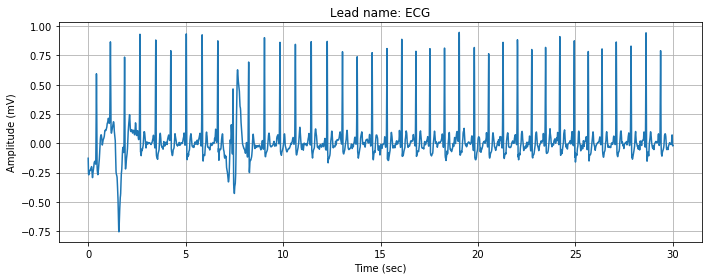

In [8]:
batch_with_data.show_ecg('A00001')

Any other action can be applied to ```batch_with_data``` in the same way as ```load```. Let's consider e.g. action [```flip_signals```](https://analysiscenter.github.io/cardio/api/cardio.batch.html#cardio.batch.EcgBatch.flip_signals). It flips signals whose R-peaks are directed downwards.

Note that ```flip_signals``` modifies batch inplace, so we create copy of the batch:

In [9]:
original_batch = batch_with_data.deepcopy()
changed_batch = batch_with_data.deepcopy()

And then apply ```flip_signal``` action:

In [10]:
changed_batch.flip_signals()

Now we can compare results. Let's consider signal with index 'A00013', whose R-peaks were originally directed downwards:

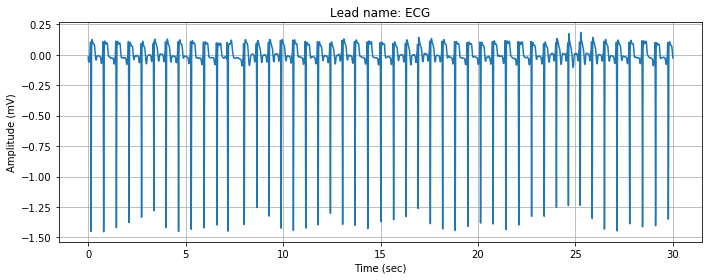

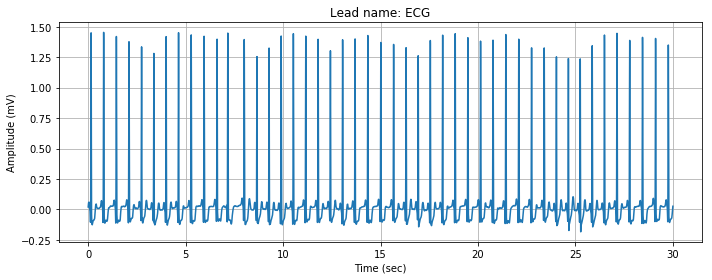

In [11]:
original_batch.show_ecg('A00013')

changed_batch.show_ecg('A00013')

For further analysis, let's apply ```flip_signals()``` to the ```batch_with_data```:

In [12]:
batch_with_data = batch_with_data.flip_signals()

## Actions in CardIO

CardIO contains a number of actions that can be applied to the batch:

* convolve_signals()
* band_pass_signals()
* random_split_signals()
* unstack_signals()
* resample_signals()
* spectrogram()
* fft()
* apply_transform()
* drop_labels()
* rename_labels()
* rename_channels()
* ...

In the following sections we will show how to use them and how these actions affect batch and its components.

### [```convolve_signals```](https://analysiscenter.github.io/cardio/api/cardio.batch.html#cardio.batch.EcgBatch.convolve_signals)

```convolve_signals()``` action actually convolves signal with the specified kernel.

Convolution is a formal mathematical operation, just as multiplication, addition, and integration. Addition takes two numbers and produces a third number, while convolution takes two signals and produces a third signal.

Let's convolve signals in batch with gaussian kernel, which look like this:

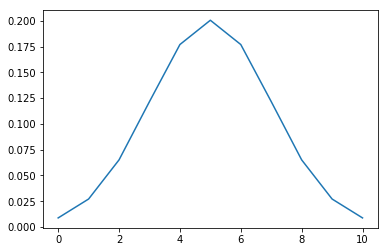

In [13]:
%matplotlib inline
import cardio 

kernel = cardio.kernels.gaussian(size=11)
plt.plot(kernel)

In [14]:
original_batch = batch_with_data.deepcopy()
changed_batch = batch_with_data.deepcopy()

This is a common operation to remove noise, so we will add some normally distributed noise to the signal and apply ```convolve_signals()```:

In [15]:
siglen = original_batch["A00001"].signal.shape[1]

noise = np.random.normal(scale=0.01, size=siglen)

original_batch["A00001"].signal += noise
changed_batch["A00001"].signal += noise

changed_batch.convolve_signals(kernel=kernel)

And now you can see how this transformation affected the signal:

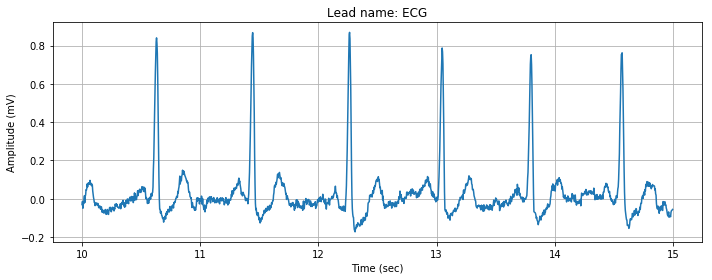

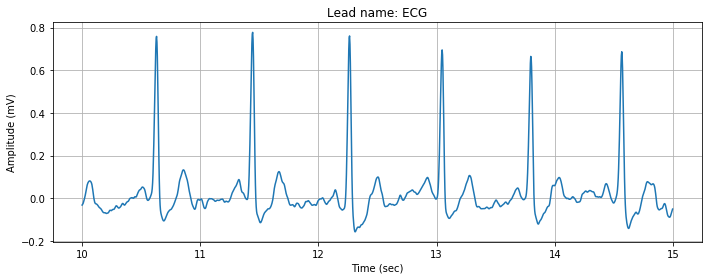

In [16]:
original_batch.show_ecg('A00001', start=10, end=15)

changed_batch.show_ecg('A00001', start=10, end=15)

### [```band_pass_signals```](https://analysiscenter.github.io/cardio/api/cardio.batch.html#cardio.batch.EcgBatch.band_pass_signals)

A bandpass filter is a device or a program that passes frequencies within a certain range and rejects frequencies outside that range. To demonstrate capabilities of ```band_pass_signal()``` action we are going to artificially modify some of the batch's signals.


In [17]:
original_batch = batch_with_data.deepcopy()
changed_batch = batch_with_data.deepcopy()

First, generate some low-frequency noise:

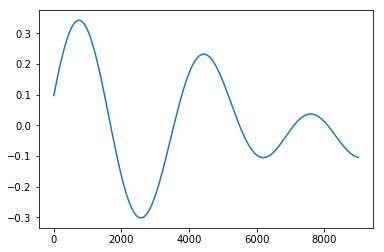

In [18]:
n_sin = 10
noise = np.zeros_like(original_batch['A00013'].signal)
t = np.linspace(0, 30, siglen)
for i in range(n_sin):
    a = np.random.uniform(0, 0.1)
    omega = np.random.uniform(0.1, 0.8)
    phi = np.random.uniform(0, 2 * np.pi)
    noise += a * np.sin(omega * t + phi)
    
plt.plot(noise[0])
plt.show()

And add this noise to the signal "A00013":

In [19]:
original_batch['A00013'].signal += noise
changed_batch['A00013'].signal += noise

Now apply band-pass filter with low frequency:

In [20]:
changed_batch.band_pass_signals(low=0.2)

And here you can see that the noise was removed:

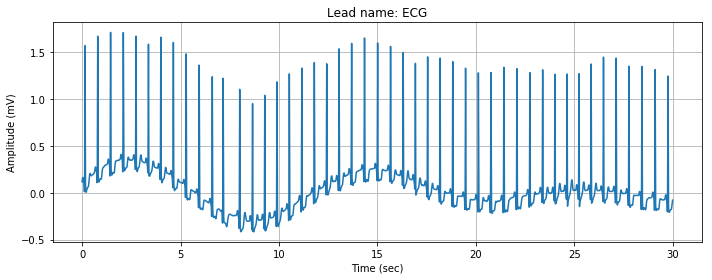

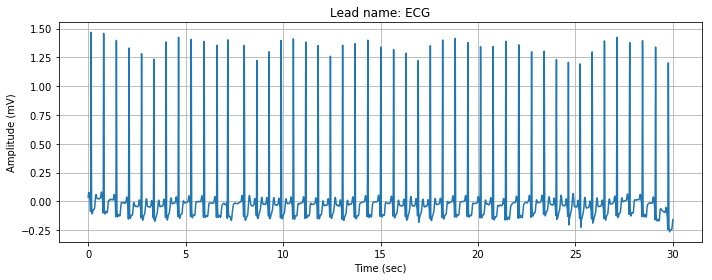

In [21]:
original_batch.show_ecg('A00013')

changed_batch.show_ecg('A00013')

### [```random_split_signals```](https://analysiscenter.github.io/cardio/api/cardio.batch.html#cardio.batch.EcgBatch.random_split_signals)

```random_split_signals()``` does simple transformation: it splits 2-D signal along time axis (typically axis 1) for ```n_segments``` with random starting point and defined ```length```.

In [22]:
original_batch = batch_with_data.deepcopy()
changed_batch = batch_with_data.deepcopy()

changed_batch.random_split_signals(length=2048, n_segments=4)

We now can compare shapes of the initial signal and after the random split. Notice, that resulting array is 3-D: ```[n_segments, n_channels, length]```.

In [23]:
print("Original shape of the signal: ", original_batch['A00013'].signal.shape)
print("Shape of the signal after random split: ", changed_batch['A00013'].signal.shape)

Original shape of the signal:  (1, 9000)
Shape of the signal after random split:  (4, 1, 2048)


### [```unstack_signals```](https://analysiscenter.github.io/cardio/api/cardio.batch.html#cardio.batch.EcgBatch.unstack_signals)

```unstack_signals()``` is useful to maintain batch structure after transformations that change shape of the signal component elements, like ```split_signals()```.
This action creates a new batch in which each signal's element along axis 0 is considered as a separate signal.

Here we apply ```split_signals()``` to both batches and then apply ```unstack_signals()``` to the changed batch:

In [24]:
original_batch = batch_with_data.deepcopy()
changed_batch = batch_with_data.deepcopy()

original_batch.split_signals(length=3000, step=6000)

changed_batch.split_signals(length=3000, step=6000).unstack_signals()

And now you can see that nothing happened:

In [25]:
print('Original shape of the signal: ', original_batch['A00013'].signal.shape)
print('Shape of the signal after actions: ', changed_batch['A00013'].signal.shape)

Original shape of the signal:  (2, 1, 3000)
Shape of the signal after actions:  (2, 1, 3000)


This happened because ```unstack_signals()``` doesn't change existing batch, but returns a new one instead.

Also, ```unstack_signals()``` changes the ```index``` of the batch. New ```indices``` will be integers from ```0``` to ```N-1```, where N is the sum of the sizes of the first dimension over all signals (3-D) in the batch. 

For example, you have batch with two 3-D signals with shapes ```[3, 12, 1000]``` and ```[2, 12, 1000]```:
``` python
>>> batch.indices
>>> ['A00001', 'A00002']
>>> batch['A00001'].signal.shape
>>> [3, 12, 1000]
>>> batch['A00002'].signal.shape
>>> [2, 12, 1000]
```
If you apply ```unstack_signals()``` to the batch you would get a new batch with five 2-D signals and new ```indices```:
``` python
>>> batch = batch.unstack_signals()
>>> batch.indices
>>> [0, 1, 2, 3, 4]
>>> batch[0].signal.shape
>>> [12, 1000]
>>> batch[3].signal.shape
>>> [12, 1000]
```

Let's use ```unstack_signals()``` on our data and see what happens:

In [26]:
original_batch = batch_with_data.deepcopy()
changed_batch = batch_with_data.deepcopy()

original_batch.split_signals(length=3000, step=6000)

changed_batch = changed_batch.split_signals(length=3000, step=6000).unstack_signals()

At first, take a glance at the ```signal``` component of the batches:

In [27]:
print('Original shape of `signal` component: ', original_batch.signal.shape)
print('Shape of `signal` component after unstack: ', changed_batch.signal.shape)

Original shape of `signal` component:  (6,)
Shape of `signal` component after unstack:  (14,)


Now we compare ```indices``` of the original and changed batches:

In [28]:
print('Indices of the original batch: ', original_batch.indices)
print('Indices of the batch after unstack: ', changed_batch.indices)

Indices of the original batch:  ['A00001' 'A00002' 'A00004' 'A00005' 'A00008' 'A00013']
Indices of the batch after unstack:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


And, finally, look at the shapes of the signals:

In [29]:
print('Original shape of the signal: ', original_batch['A00001'].signal.shape)
print('Shape of the signal after unstacking: ', changed_batch[0].signal.shape)

Original shape of the signal:  (2, 1, 3000)
Shape of the signal after unstacking:  (1, 3000)


### [```resample_signals```](https://analysiscenter.github.io/cardio/api/cardio.batch.html#cardio.batch.EcgBatch.resample_signals)

```resample_signals()``` resamples 2-D signals along time axis (axis 1) to given sampling rate. This action also changes ```signal``` and ```meta``` components.

In [30]:
original_batch = batch_with_data.deepcopy()
changed_batch = batch_with_data.deepcopy()

changed_batch.resample_signals(fs=20)

If you set new sampling rate to a very low value, you can notice changes by eye:

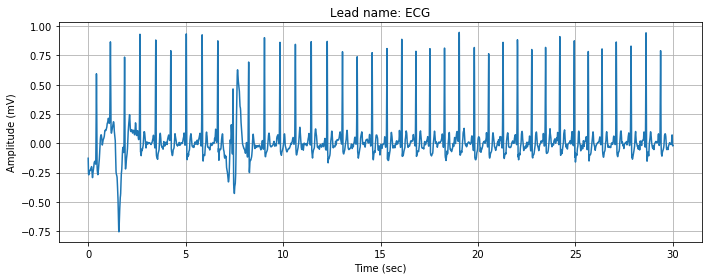

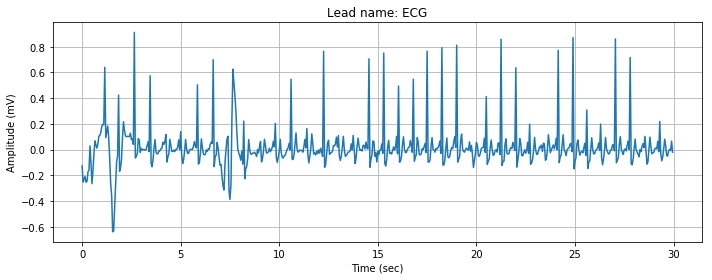

In [31]:
original_batch.show_ecg('A00001')

changed_batch.show_ecg('A00001')

And also you can see that signal length has changed:

In [32]:
print('Original shape of the signal: ', original_batch['A00001'].signal.shape)
print('Shape of the signal after resampling: ', changed_batch['A00001'].signal.shape)

Original shape of the signal:  (1, 9000)
Shape of the signal after resampling:  (1, 600)


New sampling rate is stored in ```meta``` component under key "fs":

In [33]:
print('Original sampling rate: {} Hz'.format(original_batch['A00001'].meta['fs']))
print('Sampling rate after resampling: {} Hz'.format(changed_batch['A00001'].meta['fs']))

Original sampling rate: 300 Hz
Sampling rate after resampling: 20 Hz


### [```spectrogram```](https://analysiscenter.github.io/cardio/api/cardio.batch.html#cardio.batch.EcgBatch.spectrogram)

A spectrogram is a visual representation of the spectrum of frequencies of sound or other signal as they vary with time or some other variable.

We'll use the ```spectrogram()``` action on ```changed_batch```. Note that action has a ```dst``` argument, which defines batch component (or atribute) where the result of the action will be stored.

In [34]:
changed_batch = batch_with_data.deepcopy()

changed_batch.spectrogram(dst='spectrogram_data')

Now you can retrieve the spectrogram from the ```dst``` and plot it. 


Note that ```spectrogram()``` action calculates a spectrogram for each channel, so resulting array for one 2-D signal will have three dimensions: ```[n_channels, frequency, time]```.

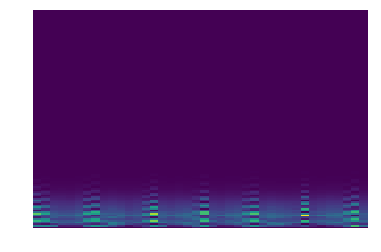

In [35]:
sig_index = changed_batch.get_pos(None, 'signal', index='A00013')
plt.pcolormesh(changed_batch.spectrogram_data[sig_index][0, :, :])
plt.axis("off")
plt.show()

### [```rfft```](https://analysiscenter.github.io/cardio/api/cardio.batch.html#cardio.batch.EcgBatch.rfft)

This action computes the one-dimensional n-point discrete Fourier Transform (DFT) of a real-valued array by means of an efficient algorithm called the Fast Fourier Transform (FFT). FFT samples a signal over a period of time (or space) and divides it into its frequency components. These components are single sinusoidal oscillations at distinct frequencies each with their own amplitude and phase. 

In [36]:
changed_batch = batch_with_data.deepcopy()

Now we apply ```rfft()``` to the ```signal``` component and store the result to the atribute ```fft_data```:

In [37]:
changed_batch.rfft(src='signal', dst='fft_data')

And the next step: calculate power spectrum and plot it. To calculate power spectrum we will square the absolute value of the spectrogram.

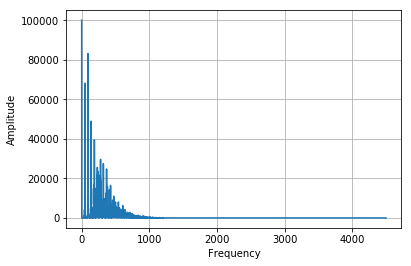

In [38]:
sig_index = changed_batch.get_pos(None, 'signal', index='A00013')

power_spectrum = np.abs(changed_batch.fft_data[sig_index][0])**2

plt.plot(power_spectrum)
plt.grid(True)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

### [```apply_transform```](https://analysiscenter.github.io/cardio/api/cardio.batch.html#cardio.batch.EcgBatch.apply_transform)

This action applies some function to each item in the batch. 


For a source ```src``` and a destination ```dst``` ```apply_transform()``` does the following:

```python
for item in range(len(batch)):
    batch.dst[item] = func(batch.src[item], *args, **kwargs)
```

```src``` and ```dst``` should be a component of a batch.

The main benefit of the ```apply_transform``` action is that it runs in parallel.

In [39]:
original_batch = batch_with_data.deepcopy()
changed_batch = batch_with_data.deepcopy()

Let's apply ```np.abs()``` function to the signals and take look at the result:

In [40]:
changed_batch.apply_transform(src='signal', dst='signal', func=np.abs)

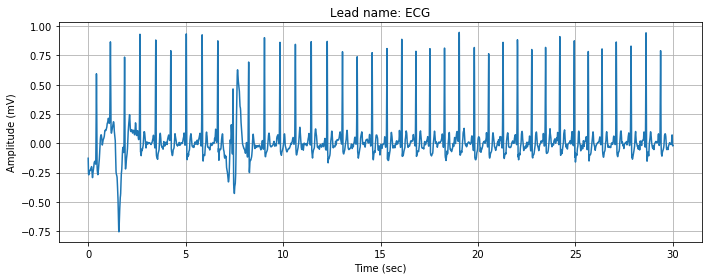

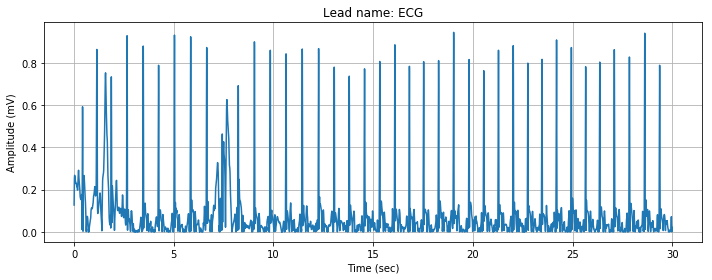

In [41]:
original_batch.show_ecg('A00001')

changed_batch.show_ecg('A00001')

### [```drop_labels```](https://analysiscenter.github.io/cardio/api/cardio.batch.html#cardio.batch.EcgBatch.drop_labels)

```drop_labels()``` removes from batch those elements, whose label is listed in the argument ```drop_list```.

In [42]:
original_batch = batch_with_data.deepcopy()
changed_batch = batch_with_data.deepcopy()

Note that this action creates a new batch, so we will call it like this:

In [43]:
changed_batch = changed_batch.drop_labels(["O"])

Now we can inspect labels in the batches:

In [44]:
print('Labels in original batch: ', original_batch.target)
print('Labels in batch after drop: ', changed_batch.target)

Labels in original batch:  ['N' 'N' 'A' 'A' 'O' 'O']
Labels in batch after drop:  ['N' 'N' 'A' 'A']


As far as this action creates new batch, it changes ```index``` of the batch, removing indices that correspond to signals with udesired label:

In [45]:
print('Indices in original batch: ', original_batch.indices)
print('Indices in batch after drop: ', changed_batch.indices)

Indices in original batch:  ['A00001' 'A00002' 'A00004' 'A00005' 'A00008' 'A00013']
Indices in batch after drop:  ['A00001' 'A00002' 'A00004' 'A00005']


### [```rename_labels```](https://analysiscenter.github.io/cardio/api/cardio.batch.html#cardio.batch.EcgBatch.rename_labels)

```rename_labels()``` simply replaces labels according to the argument ```rename_dict```.

In [46]:
original_batch = batch_with_data.deepcopy()
changed_batch = batch_with_data.deepcopy()

Suppose, we want to build a classification model to find people with arrhythmia using ECG signal. But we have data with three labels: "N" (normal), "A" (atrial fibrillation), "O" (other arrhythmias). So, all we need to do is to replace labels "A" and "O" with some other label, say "AO":

In [47]:
changed_batch = changed_batch.rename_labels(rename_dict={'A':'AO', 'O':'AO'})

Now we have only two unique labels in the target component:

In [48]:
print('Labels in original batch: ', original_batch.target)
print('Labels in batch after drop: ', changed_batch.target)

Labels in original batch:  ['N' 'N' 'A' 'A' 'O' 'O']
Labels in batch after drop:  ['N' 'N' 'AO' 'AO' 'AO' 'AO']


And you can see that property ```unique_labels``` of the batch changed too:

In [49]:
print('Labels in original batch: ', original_batch.unique_labels)
print('Labels in batch after drop: ', changed_batch.unique_labels)

Labels in original batch:  ['A', 'N', 'O']
Labels in batch after drop:  ['AO' 'N']


### [```rename_channels```](https://analysiscenter.github.io/cardio/api/cardio.batch.html#cardio.batch.EcgBatch.rename_channels)

```rename_channels()``` changes names of the channels that are stored in ```meta``` component under key "signame"`b

In [50]:
original_batch = batch_with_data.deepcopy()
changed_batch = batch_with_data.deepcopy()

If you want to change channel name from "ECG" to "Channel #1" you need to write this:

In [51]:
changed_batch = changed_batch.rename_channels(rename_dict={'ECG':'Channel #1'})

In [52]:
print('Signal names in original batch: ', original_batch["A00001"].meta["signame"])
print('Signal names in batch after drop: ', changed_batch["A00001"].meta["signame"])

Signal names in original batch:  ['ECG']
Signal names in batch after drop:  ['Channel #1']


Note that method ```show_ecg()``` now will display new name.

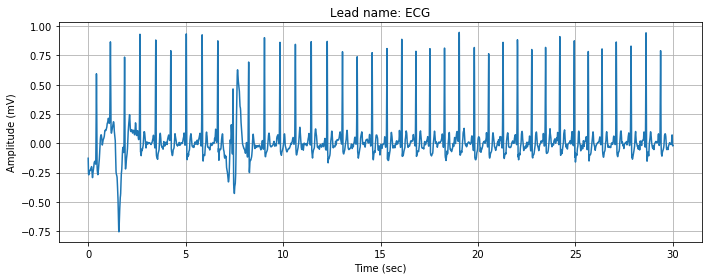

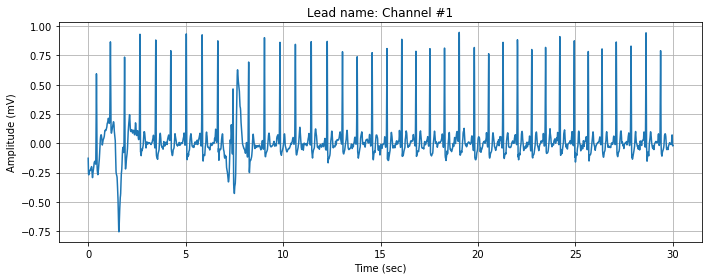

In [53]:
original_batch.show_ecg('A00001')

changed_batch.show_ecg('A00001')

## Summary

In [documentation](https://analysiscenter.github.io/cardio/api/cardio.ecg_batch.html) on EcgBatch you will find more actions that can be applied to batches.

Summarizing, in Notebook 1 we learned:
* How to get ECG data
* How to create datasets
* How to apply actions
* How different actions affect batch and its components

In the next [Notebook 2](https://github.com/analysiscenter/cardio/blob/hmm_model_update/tutorials/II.Pipelines.ipynb) we will combine actions in pipeline.